In [1]:
import pandas as pd
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm, tree, ensemble, neighbors, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, f1_score, auc, roc_auc_score, precision_score, recall_score, roc_curve, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from nltk.tokenize import TreebankWordTokenizer
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from time import time
from google.colab import drive 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def precision_recall(model, x_test, y_test):

    disp = plot_precision_recall_curve(model, x_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve')

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    punct = "[^a-zA-Z]*"
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(punct, ' ', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text
  
def rate(y_true, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp/(tp+fn)
    tnr = tn/(tn+fp)
    fpr = fp/(fp+tn)
    likelihood = tpr/fpr
    print('True Positive Rate/Rec:', np.round(tpr, 2), '- True Negative Rate/spec:', np.round(tnr, 2), '- False Positive Rate:', np.round(fpr, 2))
    return tpr, tnr, fpr, likelihood

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
df = pd.read_csv('/content/gdrive/My Drive/CNS/news-dataset.csv')

In [5]:
df.shape

(2734, 10)

In [6]:
df = df[df['body_text'].notna()]

In [7]:
df['text'] = df['body_text'].apply(preprocess)

In [8]:
df = df.drop('Unnamed: 0', axis=1)

In [9]:
sw1 = ["a","abbastanza","abbia","abbiamo","abbiano","abbiate","accidenti","ad","adesso","affinché","agl","agli","ahime","ahimè","ai","al","alcuna","alcuni","alcuno","all","alla","alle","allo","allora","altre","altri","altrimenti","altro","altrove","altrui","anche","ancora","anni","anno","ansa","anticipo","assai","attesa","attraverso","avanti","avemmo","avendo","avente","aver","avere","averlo","avesse","avessero","avessi","avessimo","aveste","avesti","avete","aveva","avevamo","avevano","avevate","avevi","avevo","avrai","avranno","avrebbe","avrebbero","avrei","avremmo","avremo","avreste","avresti","avrete","avrà","avrò","avuta","avute","avuti","avuto","basta","ben","bene","benissimo","brava","bravo","buono","c","caso","cento","certa","certe","certi","certo","che","chi","chicchessia","chiunque","ci","ciascuna","ciascuno","cima","cinque","cio","cioe","cioè","circa","citta","città","ciò","co","codesta","codesti","codesto","cogli","coi","col","colei","coll","coloro","colui","come","cominci","comprare","comunque","con","concernente","conclusione","consecutivi","consecutivo","consiglio","contro","cortesia","cos","cosa","cosi","così","cui","d","da","dagl","dagli","dai","dal","dall","dalla","dalle","dallo","dappertutto","davanti","degl","degli","dei","del","dell","della","delle","dello","dentro","detto","deve","devo","di","dice","dietro","dire","dirimpetto","diventa","diventare","diventato","dopo","doppio","dov","dove","dovra","dovrà","dovunque","due","dunque","durante","e","è","ebbe","ebbero","ebbi","ecc","ecco","ed","effettivamente","egli","ella","entrambi","eppure","era","erano","eravamo","eravate","eri","ero","esempio","esse","essendo","esser","essere","essi","ex","fa","faccia","facciamo","facciano","facciate","faccio","facemmo","facendo","facesse","facessero","facessi","facessimo","faceste","facesti","faceva","facevamo","facevano","facevate","facevi","facevo","fai","fanno","farai","faranno","fare","farebbe","farebbero","farei","faremmo","faremo","fareste","faresti","farete","farà","farò","fatto","favore","fece","fecero","feci","fin","finalmente","finche","fine","fino","forse","forza","fosse","fossero","fossi","fossimo","foste","fosti","fra","frattempo","fu","fui","fummo","fuori","furono","futuro","generale","gente","gia","giacche","giorni","giorno","giu","già","gli","gliela","gliele","glieli","glielo","gliene","grande","grazie","gruppo","ha","haha","hai","hanno","ho","i","ie","ieri","il","improvviso","in","inc","indietro","infatti","inoltre","insieme","intanto","intorno","invece","io","l","la","lasciato","lato","le","lei","li","lo","lontano","loro","lui","lungo","luogo","là","ma","macche","magari","maggior","mai","male","malgrado","malissimo","me","medesimo","mediante","meglio","meno","mentre","mesi","mezzo","mi","mia","mie","miei","mila","miliardi","milioni","minimi","mio","modo","molta","molti","moltissimo","molto","momento","mondo","ne","negl","negli","nei","nel","nell","nella","nelle","nello","nemmeno","neppure","nessun","nessuna","nessuno","niente","no","noi","nome","non","nondimeno","nonostante","nonsia","nostra","nostre","nostri","nostro","novanta","nove","nulla","nuovi","nuovo","o","od","oggi","ogni","ognuna","ognuno","oltre","oppure","ora","ore","osi","ossia","ottanta","otto","paese","parecchi","parecchie","parecchio","parte","partendo","peccato","peggio","per","perche","perchè","perché","percio","perciò","perfino","pero","persino","persone","però","piedi","pieno","piglia","piu","piuttosto","più","po","pochissimo","poco","poi","poiche","possa","possedere","posteriore","posto","potrebbe","preferibilmente","presa","press","prima","primo","principalmente","probabilmente","promesso","proprio","puo","pure","purtroppo","può","qua","qualche","qualcosa","qualcuna","qualcuno","quale","quali","qualunque","quando","quanta","quante","quanti","quanto","quantunque","quarto","quasi","quattro","quel","quella","quelle","quelli","quello","quest","questa","queste","questi","questo","qui","quindi","quinto","realmente","recente","recentemente","registrazione","relativo","riecco","rispetto","salvo","sara","sarai","saranno","sarebbe","sarebbero","sarei","saremmo","saremo","sareste","saresti","sarete","sarà","sarò","scola","scopo","scorso","se","secondo","seguente","seguito","sei","sembra","sembrare","sembrato","sembrava","sembri","sempre","senza","sette","si","sia","siamo","siano","siate","siete","sig","solito","solo","soltanto","sono","sopra","soprattutto","sotto","spesso","sta","stai","stando","stanno","starai","staranno","starebbe","starebbero","starei","staremmo","staremo","stareste","staresti","starete","starà","starò","stata","state","stati","stato","stava","stavamo","stavano","stavate","stavi","stavo","stemmo","stessa","stesse","stessero","stessi","stessimo","stesso","steste","stesti","stette","stettero","stetti","stia","stiamo","stiano","stiate","sto","su","sua","subito","successivamente","successivo","sue","sugl","sugli","sui","sul","sull","sulla","sulle","sullo","suo","suoi","tale","tali","talvolta","tanto","te","tempo","terzo","th","ti","titolo","tra","tranne","tre","trenta","triplo","troppo","trovato","tu","tua","tue","tuo","tuoi","tutta","tuttavia","tutte","tutti","tutto","uguali","ulteriore","ultimo","un","una","uno","uomo","va","vai","vale","vari","varia","varie","vario","verso","vi","vicino","visto","vita","voi","volta","volte","vostra","vostre","vostri","vostro"]
sw2 = ['the', 'via', 'totale', 'settimane', 'spiega', 'situazione', 'non', 'san', 'settimana', 'la', 'il', 'dell', '--', '-' ,'–', '%', 'almeno','far', 'new','bisogno', ':', 'dell']

sw = sw1+sw2

In [10]:
tf_idf = TfidfVectorizer(lowercase=True, analyzer='word')
tokenizer = TreebankWordTokenizer()

tf_idf.set_params(tokenizer=tokenizer.tokenize)
#tf_idf.set_params(stop_words=sw)
tf_idf.set_params(ngram_range=(1, 2))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<bound method TreebankWordTokenizer.tokenize of <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x7f922baaa470>>,
                use_idf=True, vocabulary=None)

In [12]:
x = tf_idf.fit_transform(df['text'])
y = df.iloc[:, -2]

In [13]:
print(x.shape)
print(y.shape)

(2639, 691)
(2639,)


In [14]:
print(df[df.reliability == 0].shape)
print(df[df.reliability == 1].shape)

(447, 10)
(2192, 10)


In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [17]:
CLASSES = ['is_unreliable', 'is_reliable']

In [18]:
model = {
        linear_model.LogisticRegression(): {'penalty': ['l1', 'l2', 'none'],
                                            'C': [0.01, 0.1, 1.0],
                                            'solver': ['liblinear', 'sag', 'saga']},
        neighbors.KNeighborsClassifier(): {'n_neighbors': range(1,100,4),
                                           'weights': ['uniform', 'distance'],
                                           'p': [1, 2]},
        ensemble.RandomForestClassifier(): {'n_estimators': range(10,200,10),
                                            'criterion': ['gini', 'entropy'],
                                            'max_features': ['log2', 'sqrt', None]},
        tree.DecisionTreeClassifier(): {'criterion': ['gini', 'entropy'],
                                        'max_features': ['sqrt', 'log2', None]},
        svm.SVC(): {'C': [0.01, 0.1, 1.0, 2.0],
                    'degree': [1, 2, 3, 4, 5],
                    'kernel': ['linear',  'poly', 'rbf', 'sigmoid'],
                    'gamma': [0.01, 0.1, 1.0, 'scale', 'auto']}
         
        }

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


29.379019737243652
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
True Positive Rate/Rec: 0.22 - True Negative Rate/spec: 0.97 - False Positive Rate: 0.03
True Positive Rate/Rec: 0.22 - True Negative Rate/spec: 0.97 - False Positive Rate: 0.03
True Positive Rate/Rec: 0.22 - True Negative Rate/spec: 0.97 - False Positive Rate: 0.03
               precision    recall  f1-score   support

is_unreliable       0.59      0.22      0.32        90
  is_reliable       0.86      0.97      0.91       438

     accuracy                           0.84       528
    macro avg       0.72      0.60      0.62       528
 weighted avg       0.81      0.84      0.81       528

Confusion matrix, without normalization
[[ 20  70]
 [ 

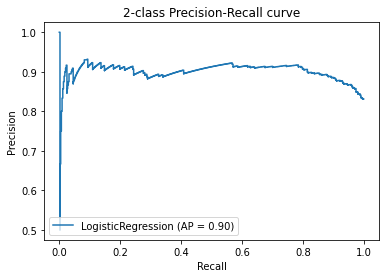

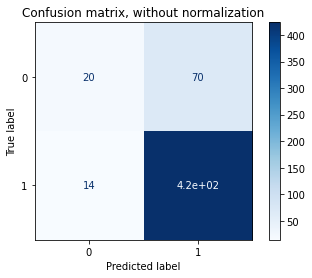

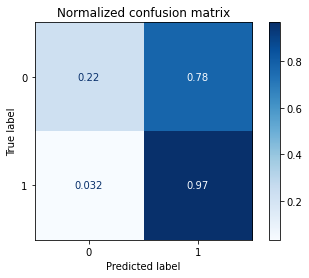


-------------------------------------------------------------------------
-------------------------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


386.75680017471313
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
True Positive Rate/Rec: 0.21 - True Negative Rate/spec: 0.92 - False Positive Rate: 0.08
True Positive Rate/Rec: 0.21 - True Negative Rate/spec: 0.92 - False Positive Rate: 0.08
True Positive Rate/Rec: 0.21 - True Negative Rate/spec: 0.92 - False Positive Rate: 0.08
               precision    recall  f1-score   support

is_unreliable       0.34      0.21      0.26        90
  is_reliable       0.85      0.92      0.88       438

     accuracy                           0.80       528
    macro avg       0.59      0.56      0.57       528
 weighted avg       0.76      0.80      0.78       528

Confusion matrix, without normalization
[[ 19  71]
 [ 37 401]]
Normalized confusion matrix
[[0.21111111 0.78888889]
 [0.08447489 0.91552511]]


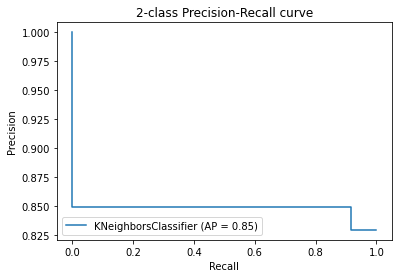

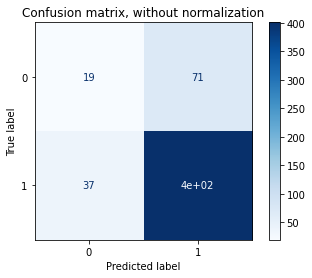

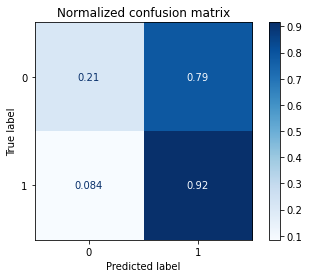


-------------------------------------------------------------------------
-------------------------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


11387.018528461456
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
True Positive Rate/Rec: 0.2 - True Negative Rate/spec: 0.95 - False Positive Rate: 0.05
True Positive Rate/Rec: 0.2 - True Negative Rate/spec: 0.95 - False Positive Rate: 0.05
True Positive Rate/Rec: 0.2 - True Negative Rate/spec: 0.95 - False Positive Rate: 0.05
               precision    recall  f1-score   support

is_unreliable       0.45      0.20      0.28        90
  is_reliable       0.85      0.95      0.90       438

   

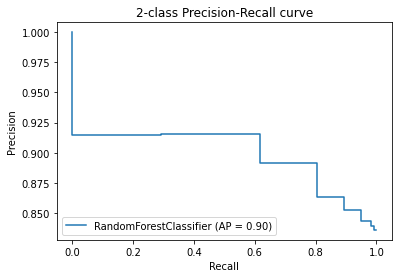

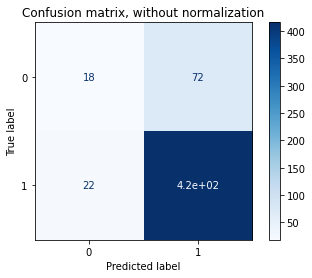

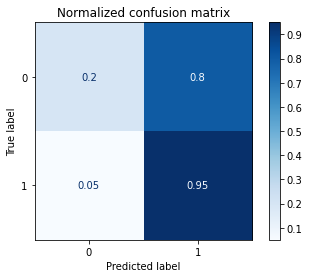


-------------------------------------------------------------------------
-------------------------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


10.833465814590454
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
True Positive Rate/Rec: 0.32 - True Negative Rate/spec: 0.86 - False Positive Rate: 0.14
True Positive Rate/Rec: 0.32 - True Negative Rate/spec: 0.86 - False Positive Rate: 0.14
True Positive Rate/Rec: 0.32 - True Negative Rate/spec: 0.86 - False Positive Rate: 0.14
               precision    recall  f1-score   support

is_unreliable       0.32      0.32      0.32        90
  is_reliable       0.86      0.86      0.86       438

     accuracy                           0.77       528
    macro avg       0.59      0.59      0.59       528
 weighted 

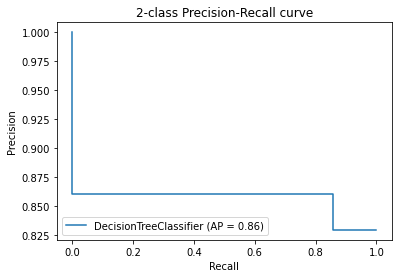

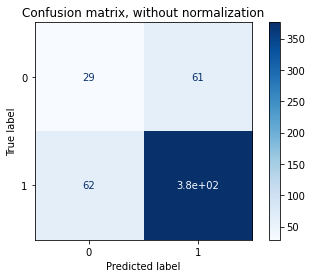

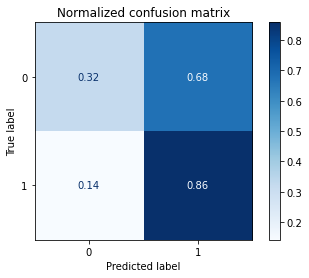


-------------------------------------------------------------------------
-------------------------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


3669.0904738903046
SVC(C=2.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


True Positive Rate/Rec: 0.02 - True Negative Rate/spec: 1.0 - False Positive Rate: 0.0
True Positive Rate/Rec: 0.02 - True Negative Rate/spec: 1.0 - False Positive Rate: 0.0
True Positive Rate/Rec: 0.02 - True Negative Rate/spec: 1.0 - False Positive Rate: 0.0
               precision    recall  f1-score   support

is_unreliable       1.00      0.02      0.04        90
  is_reliable       0.83      1.00      0.91       438

     accuracy                           0.83       528
    macro avg       0.92      0.51      0.48       528
 weighted avg       0.86      0.83      0.76       528

Confusion matrix, without normalization
[[  2  88]
 [  0 438]]
Normalized confusion matrix
[[0.02222222 0.97777778]
 [0.         1.        ]]


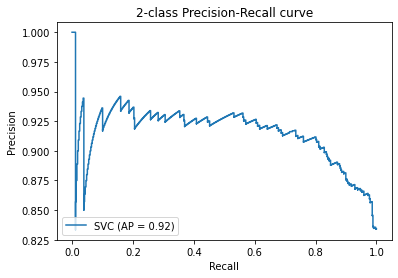

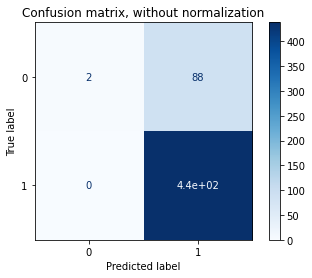

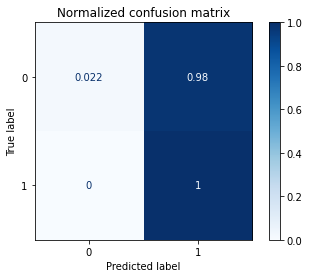


-------------------------------------------------------------------------
-------------------------------------------------------------------------



,Model Name,Model TPR,Model TNR,Model FPR,Model Precision micro,Model Recall micro,Model F1 micro,Model ROC AUC micro,Model AP micro,Model AUC
3,DecisionTreeClassifier,0.32,0.86,0.14,0.77,0.77,0.77,0.59,0.86,0.59
1,KNeighborsClassifier,0.21,0.92,0.08,0.80,0.80,0.80,0.56,0.85,0.56
2,RandomForestClassifier,0.20,0.95,0.05,0.82,0.82,0.82,0.57,0.85,0.71
4,SVC,0.02,1.00,0.00,0.83,0.83,0.83,0.51,0.83,NaN
0,LogisticRegression,0.22,0.97,0.03,0.84,0.84,0.84,0.60,0.86,0.72


In [19]:
model_columns = []
model_compare = pd.DataFrame(columns = model_columns)


row_index = 0
for alg, grid in model.items():


    kf = KFold(5, shuffle=True)
    
    t0 = time()
    gs = GridSearchCV(estimator = alg, param_grid = grid, scoring='precision', n_jobs=4, iid=False, cv=kf, refit=True)

    
    gs.fit(x_train, y_train)
    research_time = time() - t0
    print(research_time)
    alg = gs.best_estimator_
    print(alg)
    
    predicted = alg.predict(x_test)



    model_name = alg.__class__.__name__
    model_compare.loc[row_index,'Model Name'] = model_name
    model_compare.loc[row_index, 'Model TPR'] = round(rate(y_test, predicted)[0],2)
    model_compare.loc[row_index, 'Model TNR'] = round(rate(y_test, predicted)[1],2)
    model_compare.loc[row_index, 'Model FPR'] = round(rate(y_test, predicted)[2],2)
    model_compare.loc[row_index, 'Model Precision micro'] = round(precision_score(y_test, predicted, average='micro'),2)
    model_compare.loc[row_index, 'Model Recall micro'] = round(recall_score(y_test, predicted, average='micro'),2)
    model_compare.loc[row_index, 'Model F1 micro'] = round(f1_score(y_test, predicted, average='micro'),2)
    model_compare.loc[row_index, 'Model ROC AUC micro'] = round(roc_auc_score(y_test, predicted, average='micro'),2)
    model_compare.loc[row_index, 'Model AP micro'] = round(average_precision_score(y_test, predicted, average='micro'),2)

    print(classification_report(y_test, predicted, target_names=CLASSES))
    precision_recall(alg, x_test, y_test)

    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(alg, x_test, y_test,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)
        


    plt.show()


    row_index+=1
    print()
    print('-------------------------------------------------------------------------')
    print('-------------------------------------------------------------------------')
    print()
    
model_compare.sort_values(by = ['Model Precision micro'], ascending = True, inplace = True)    
model_compare

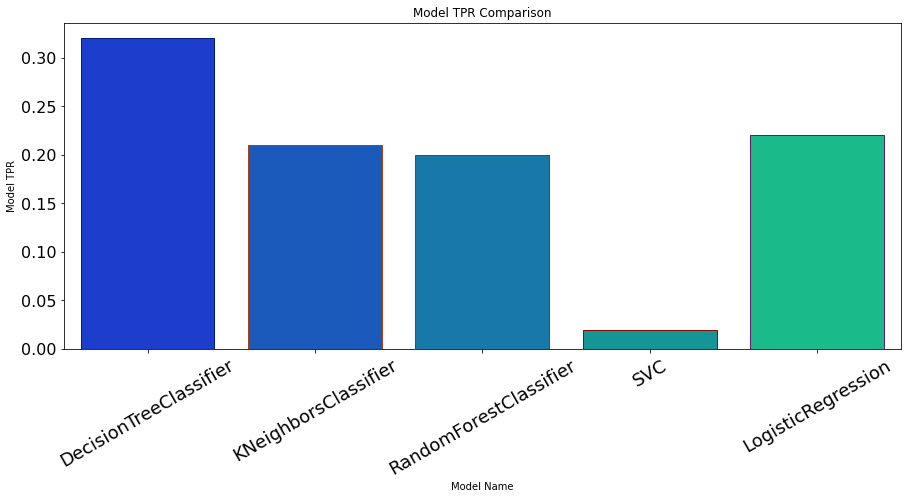

In [20]:
plt.subplots(figsize=(15,6))
sns.barplot(x="Model Name", y="Model TPR",data=model_compare,palette='winter',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=30, fontsize=18)
plt.yticks(fontsize=16)
plt.title('Model TPR Comparison')
plt.show()

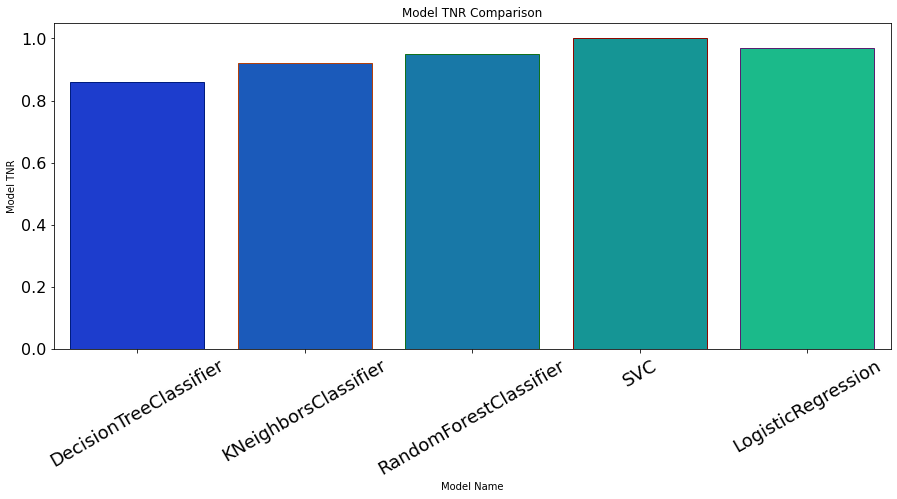

In [21]:
plt.subplots(figsize=(15,6))
sns.barplot(x="Model Name", y="Model TNR",data=model_compare,palette='winter',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=30, fontsize=18)
plt.yticks(fontsize=16)
plt.title('Model TNR Comparison')
plt.show()

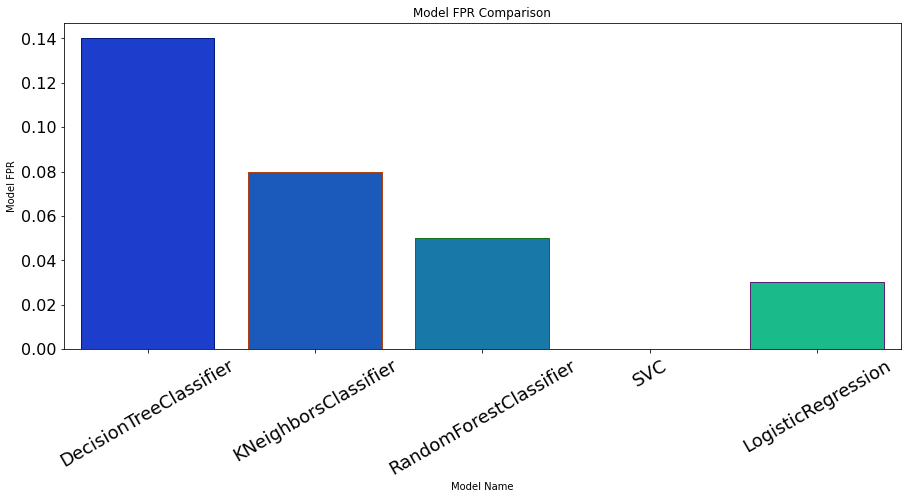

In [22]:
plt.subplots(figsize=(15,6))
sns.barplot(x="Model Name", y="Model FPR",data=model_compare,palette='winter',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=30, fontsize=18)
plt.yticks(fontsize=16)
plt.title('Model FPR Comparison')
plt.show()

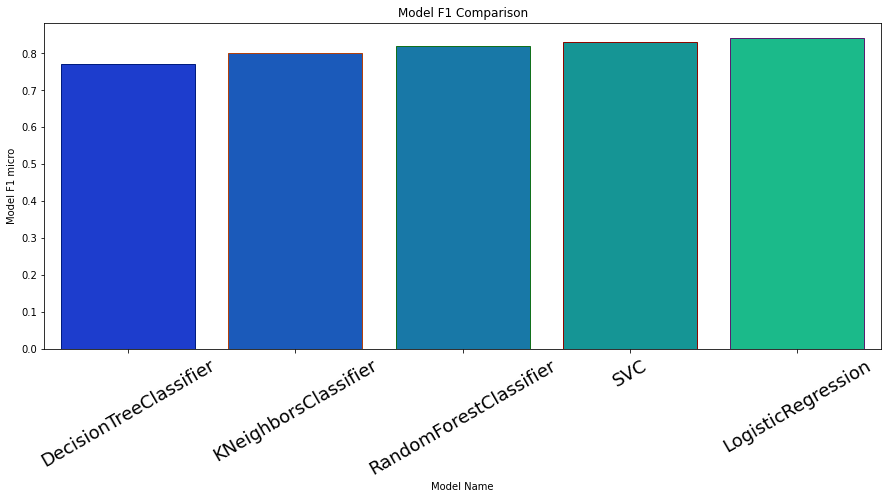

In [23]:
plt.subplots(figsize=(15,6))
sns.barplot(x="Model Name", y="Model F1 micro",data=model_compare,palette='winter',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=30, fontsize=18)
plt.title('Model F1 Comparison')
plt.show()

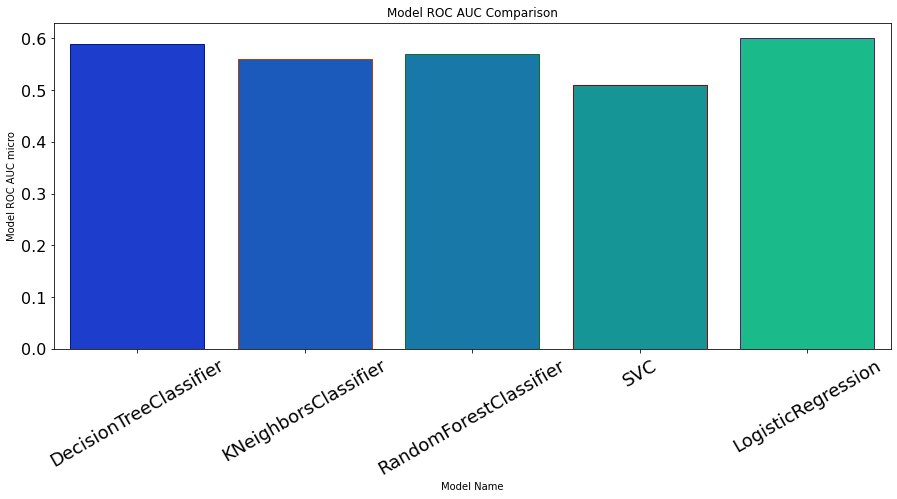

In [24]:
plt.subplots(figsize=(15,6))
sns.barplot(x="Model Name", y="Model ROC AUC micro",data=model_compare,palette='winter',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=30, fontsize=18)
plt.yticks(fontsize=16)
plt.title('Model ROC AUC Comparison')
plt.show()

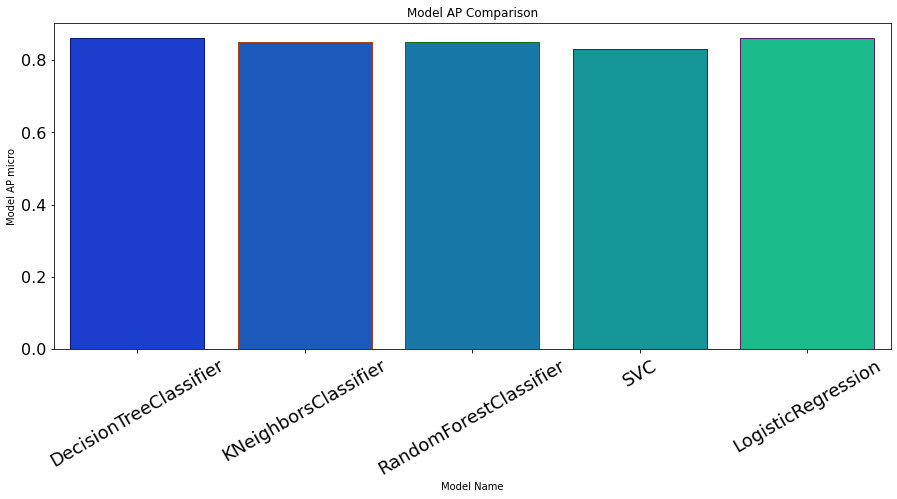

In [27]:
plt.subplots(figsize=(15,6))
sns.barplot(x="Model Name", y="Model AP micro",data=model_compare,palette='winter',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=30, fontsize=18)
plt.yticks(fontsize=16)
plt.title('Model AP Comparison')
plt.show()